Body size and range size relationship of avian scavengers
=================

[1. Proposal](#1-proposal)

[2. Preamble](#2-preamble)

[3. Data exploration](#3-data-exploration)

[4. Analyses](#4-analyses)

[4.1 Global avian scavengers without dietary distinction](#4.1-global-avian-scavengers-without-dietary-distinction)

[4.2 Obligate and facultative scavengers](#4.2-obligate-and-facultative-scavengers)

[5. References](#5-references)

# 1. Proposal

* Explain the triangle-shaped distribution
* More clearly state hypotheses and rationale

## Background

* Original hypothesis was that we would see a positive relationship, but this was before we expanded to global birds. But note that there's an effective size limit on how big birds can get
1. We expect to see a slightly negative relationship when looking at scavengers as a whole due to the number of obligate scavengers dominating the large body size classes that have small EOOs; the extremeness of the large size paired with the small EOO of those obligates may be enough to affect the linear relationship across all species, contrary to the expected relationship between bigger body sizes and larger EOOs [cite: Brown and Maurer 1989]. 
2. We anticipate that separating the obligate and facultative scavengers into their own groups will reveal different BSRS relationships. The range size of obligate scavengers will be limited by body size, because they are so large they must remain in geographic areas that facilitate flight, such as the Andean condor living in exclusively mountainous regions with strong updrafts [CITATION]. Therefore, we expect to see a negative relationship between BS and RS. However, facultative scavengers may show a positive body size-range size relationship that more closely matches the expectations outlined by Brown and Maurer 1989, because we are considering so many more species with a greater variability in body sizes; refer to that paper that showed mammals with bigger body sizes are kinda ecologically required to have larger ranges.

<!-- The range size of obligate scavengers will be limited by body size, because we have so many large sp within this group and will drag the line down -->

## Objectives

### Significance

* Highlights the importance of scale in macroecological research. What we already recognize in macroecology of that "rule" in macroecology of larger body sizes means larger range sizes and that diff patterns can be viewed at different scales, and the further we break down relationships between taxa the more the "rule" of BSRS disintegrates.
* Looks at that rule of BSRS [cite Brown and Maurer 1989] and looks at how that rule breaks down as we change the taxonomic scale under consideration.

### Methods

We will study 65 species of 22 obligate and 43 facultative avian scavengers from around the world. eBird is a bird-watching database with a wealth of observation records that we will use to calculate the extent of occurrence (EOO) of each species.

We draw from the methods used by [Blackburn and Gaston (1986)](https://www.jstor.org/stable/56368) to evaluate the relationship between the body size and the range size of obligate and facultative avian scavenger species. First we examine them as a single entity and then compare the effect diet strategy may have on the body size-range size relationship.

# 2. Preamble

Import libraries and set global options.

In [1]:
import pandas as pd  # For manipulating data structures
import numpy as np  # For mathematical functions
import scipy.stats as stats  # Algorithms and convenience functions built on NumPy
import statsmodels.api as sm  # For statistical methods
import matplotlib.pyplot as plt  # Essentially the Python equivalent to ggplot2
import seaborn as sns  # A library for statistical graphics built on Matplotlib

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
}
sns.set_theme(
    context="notebook",
    style="ticks",
    palette="colorblind",
    rc=custom_params,
)

Read the cleaned data, indexing by species name to make working with the DataFrame more intuitive.

In [2]:
scavengers = pd.read_csv("../data/cleaned scavenger data.csv", index_col="Species name")

scavengers.drop(
    ["BirdLife Extent of occurrence"], axis=1, inplace=True
)  # This column is not used in this file, so removing it for clarity
scavengers.head()

,Scientific name,Diet,Extent of occurrence,Body size,log Extent of occurrence,log Body size
Species name,,,,,,
Black vulture,Coragyps atratus,Obligate,42593865.0,2200,7.629347,3.342423
Turkey vulture,Cathartes aura,Obligate,52285085.0,2500,7.718378,3.397940
Lesser yellow headed vulture,Cathartes burrovianus,Obligate,19989926.0,950,7.300811,2.977724
Greater yellow headed vulture,Cathartes melambrotus,Obligate,7481821.0,1650,6.874007,3.217484
King vulture,Sarcoramphus papa,Obligate,17390218.0,3800,7.240305,3.579784


Let's also make separate Pandas DataFrames for obligate and scavenger species.

In [3]:
obligates = scavengers.loc[scavengers["Diet"] == "Obligate"]
facultatives = scavengers.loc[scavengers["Diet"] == "Facultative"]

# 3. Data exploration

Plotting the data on a $log_{10}$ scale below shows signs that scavengers tend towards having larger EOOs, though there does not seem to be a linear relationship between EOO and body size.

When we consider obligates, however, there does seem to potentially be a negative linear relationship where larger obligate scavengers will have smaller range sizes. Facultative scavengers continue to seemingly not have a strong relationship between body size and range size.

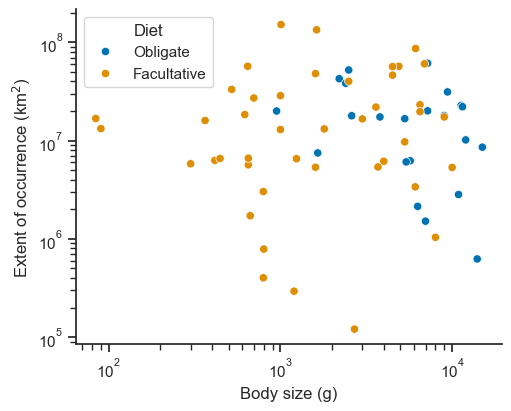

In [37]:
fig, ax = plt.subplots(1,1, figsize=(5,4), layout="constrained")

sns.scatterplot(
    data=scavengers,
    x="Body size",
    y="Extent of occurrence",
    hue="Diet",
)
ax.set_ylabel("Extent of occurrence (km$^2$)")
ax.set_xlabel("Body size (g)")
plt.yscale("log")
plt.xscale("log")

plt.show()

Blackburn and Gaston (1989) suggest that a square root transformation for an area variable such as EOO might make more sense, but at the expense of comparing results with previous research. Since that is explicitly what we are doing, we will also not square root transform the EOO.

## 3.1.1 Histograms

Disclaimer: I used Copilot for help refactoring the following code block when my for loops kept failing to combine the raw and log-transformed data.

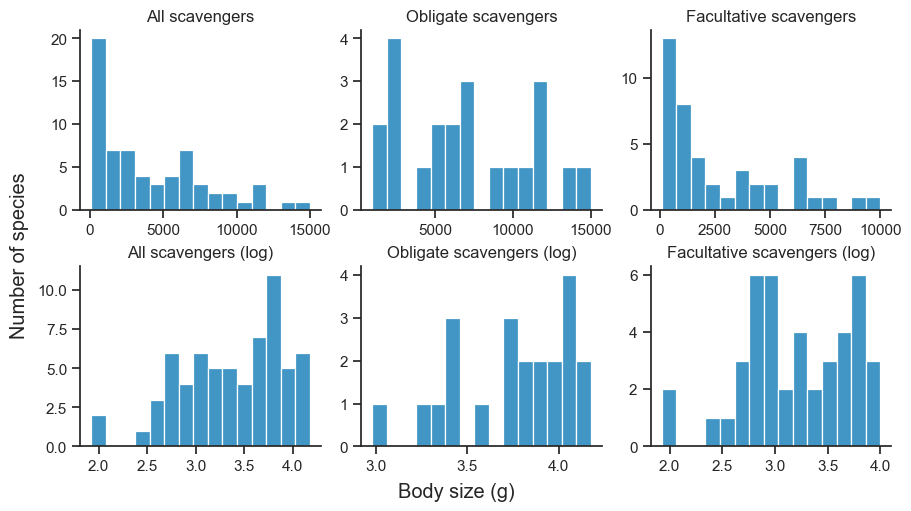

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(9, 5), layout="constrained")

data = [scavengers, obligates, facultatives]
titles = ["All scavengers", "Obligate scavengers", "Facultative scavengers"]

# Plot the first row of histograms with raw data
for ax, d, title in zip(axes[0], data, titles):
    sns.histplot(ax=ax, data=d, x=d["Body size"], bins=15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title)

# Plot the second row with log-transformed data
for ax, d, title in zip(axes[1], data, titles):
    sns.histplot(ax=ax, data=d, x=d["log Body size"], bins=15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title + " (log)")

# Set figure-level labels
fig.supxlabel("Body size (g)")
fig.supylabel("Number of species")

plt.show()

The above log-transformed histograms for "All scavengers" and "Facultative scavengers" look similar to Figure 1, C and D in Brown and Maurer (1989) when they reduced their spatial scale. Our histograms suggest a similar effect may be achieved by narrowing the taxonomic focus while maintaining a large geographic scale; in this case, a global one. "Obligate scavengers" looks more similar to when the spatial scale is highly restricted (Fig. 1; E, F), and have more larger-bodied species. This may be due to energetic constraints and diet, where animals with large body sizes can consume lower-quality food in greater quantities, and extract more nutrients with the higher-capacity digestive system (Brown and Maurer, 1989). And what's lower quality food than a literal corpse?

-------------
# 4. Analyses

We log-transform both variables to make the data approximately linear to meet the assumptions of a classical linear regression model that uses OLS. Since we are able to meet the assumptions, we don't need the added flexibility that a generalized linear model provides.

## 4.1 Global avian scavengers without dietary distinction

**Define the variables**

Linear models are at their core just a bunch of matrices in a trench coat, though we don't often think of them like this.
Written out as matrices, the linear equation $y=X\beta+\epsilon$ looks like

$$
\begin{equation}
    \begin{bmatrix}
        y_1 \cr
        y_2 \cr
        \vdots \cr
        y_n
    \end{bmatrix}
    =
    \begin{bmatrix}
        1 & x_1 \cr
        1 & x_2 \cr
        \vdots & \vdots \cr
        1 & x_n
    \end{bmatrix}
    \cdot
    \begin{bmatrix}
        \beta_0 \cr
        \beta_1
    \end{bmatrix}
    +
    \begin{bmatrix}
        \epsilon_1 \cr
        \epsilon_2 \cr
        \vdots \cr
        \epsilon_n
    \end{bmatrix}
\end{equation}
$$

The design matrix, $X$, is handled differently between different libraries, whether working in R or Python. In our case, the Statsmodels library does not include a constant term by default in the `OLS` function, so we must do this ourselves.
This is done with the `add_constant` function to add a constant term to the linear equation. ([Statsmodels tools.add_constant](https://www.statsmodels.org/stable/generated/statsmodels.tools.tools.add_constant.html), [.pyTutorial, 2025.](https://pytutorial.com/python-statsmodels-add_constant-explained/)).

The design matrix will come up again in section [4.2 Obligate and facultative scavengers](#4.2-Obligate-and-facultative-scavengers).

<!-- The intercept term is the expected value of the dependent variable when the fixed variables are zero. -->
<!-- The way to do this is with the `add_constant` function to add a constant term, which is the intercept of the regression line. What `add_constant` does is it adds a column of ones to the dataset. -->

In [58]:
# Define the X and Y matrices
y = scavengers["log Extent of occurrence"]
x = scavengers["log Body size"]

# Add a column called "const" to the design matrix.
x = sm.add_constant(x)
x.head()

,const,log Body size
Species name,,
Black vulture,1.0,3.342423
Turkey vulture,1.0,3.397940
Lesser yellow headed vulture,1.0,2.977724
Greater yellow headed vulture,1.0,3.217484
King vulture,1.0,3.579784


**Fit the OLS model** 

Note: `fit` uses the Moore-Penrose pseudoinverse method ([Statsmodels OLS.fit](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit.html)), a commonly used method to solve the least squares system of linear equations ([Wolfram Mathworld, Moore-Penrose Matrix Inverse](https://mathworld.wolfram.com/Moore-PenroseMatrixInverse.html)).

In [59]:
ols_model = sm.OLS(y, x).fit()

print(ols_model.summary())

                               OLS Regression Results                               
Dep. Variable:     log Extent of occurrence   R-squared:                       0.000
Model:                                  OLS   Adj. R-squared:                 -0.015
Method:                       Least Squares   F-statistic:                   0.03002
Date:                      Mon, 14 Apr 2025   Prob (F-statistic):              0.863
Time:                              17:46:17   Log-Likelihood:                -62.251
No. Observations:                        65   AIC:                             128.5
Df Residuals:                            63   BIC:                             132.9
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

The `coef` column shows the OLS regression coefficients, from which we can determine our regression equation:

$y_i = \beta_0 + \beta_1x_i$

EOO $_i$ = 16.02 + 0.0261 $\cdot$(Body size $_i$)

This is practically a flat line, shown below, indicating that there's no relationship between body size and EOO across avian scavengers. This is corroborated by the $R^2$ value of <0.05 and the large p-value, 0.863, also suggests no relationship between body size and range size in avian scavengers.

The Jarque-Bera test statistic is quite large (9.479) and indicates that the residuals are not normally distributed, and the small Jarque-Bera p-value (p < 0.00874) says that there is a low probability of sampling from a normal distribution.

However, the Jarque-Bera test is better suited for larger sample sizes ([SciPy User Guide, Jarque-Bera goodness of fit test](https://docs.scipy.org/doc/scipy/tutorial/stats/hypothesis_jarque_bera.html#hypothesis-jarque-bera)), so let's assess the normality of the residuals with basic descriptive statistics.

In [77]:
ols_residuals = ols_model.resid
ols_fitted = ols_model.fittedvalues

ols_residuals.describe()

count    6.500000e+01
mean     1.325435e-15
std      6.354159e-01
min     -1.963329e+00
25%     -2.701634e-01
50%      1.744652e-01
75%      4.232809e-01
max      1.146722e+00
dtype: float64

The `50` percentile is the same as the `median`, which is fairly small at 0.4 

<Axes: >

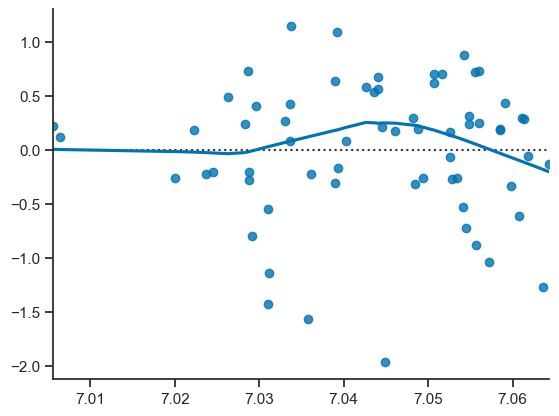

In [78]:
sns.residplot(x=ols_fitted, y=ols_residuals, lowess=True)

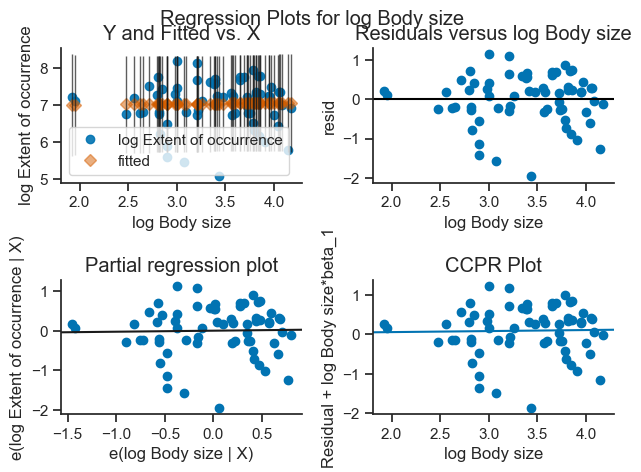

In [75]:
sm.graphics.plot_regress_exog(results=ols_model, exog_idx="log Body size")
fig.tight_layout(pad=1.0)

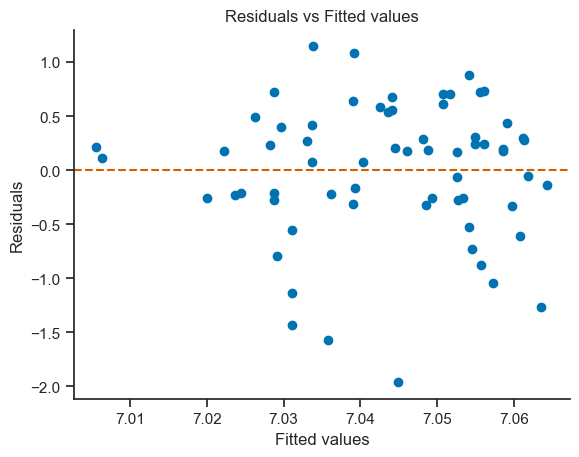

In [80]:

plt.scatter(ols_fitted, ols_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted values")
plt.show()


Make a Q-Q plot and include a standardized line.

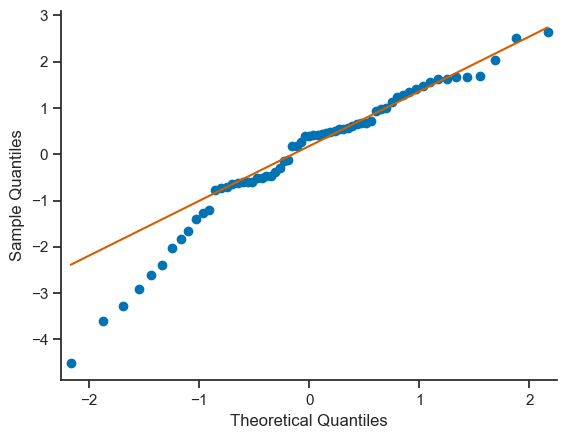

In [33]:
sm.qqplot(ols_model.resid, line="q")
plt.show()  # Needed to prevent Statsmodels from printing two identical plots.

Text(0, 0.5, 'EOO (km$^2$)')

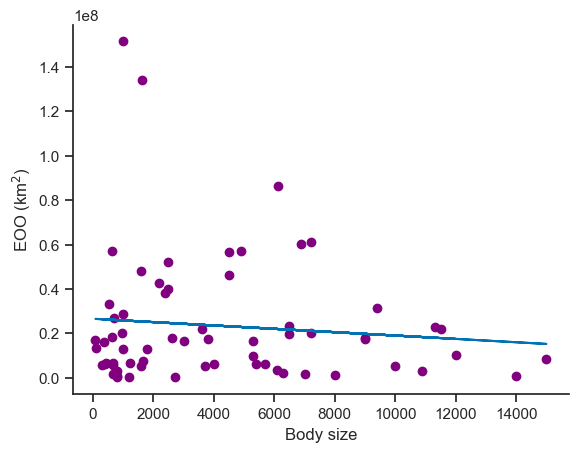

In [ ]:
# Fit a polynomial with least squares polynomial fit
a, b = np.polyfit(
    x=scavengers["Body size"], y=scavengers["Extent of occurrence"], deg=1
)

plt.scatter(
    y=scavengers["Extent of occurrence"], x=scavengers["Body size"], color="purple"
)
plt.plot(scavengers["Body size"], a * scavengers["Body size"] + b)

plt.xlabel("Body size (g)")
plt.ylabel("EOO (km$^2$)")

# plt.text(1, 90, "y = " + "{:.3f}".format(b) + " + {:.3f}".format(a) + "x", size=12)
# plt.xscale("log")

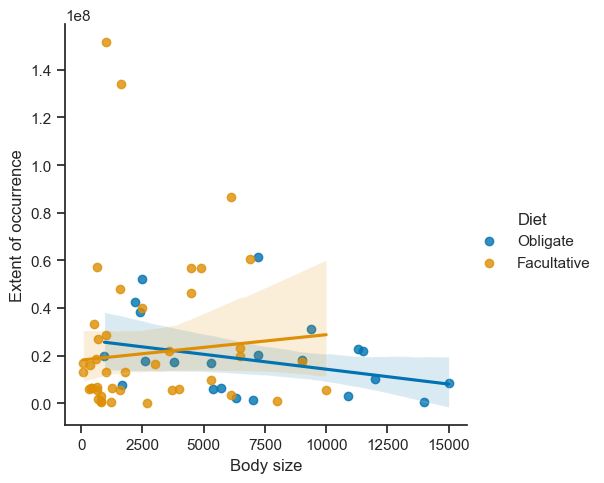

In [51]:
sns.lmplot(
    x="Body size",
    y="Extent of occurrence",
    hue="Diet",
    data=scavengers,
    scatter=True,
    legend=True,
    # logx=True,
    robust=True
)

### GLM test

In [82]:
glm_model = sm.GLM(y, x, family=sm.families.Gaussian()).fit()

print(glm_model.summary())

                    Generalized Linear Model Regression Results                     
Dep. Variable:     log Extent of occurrence   No. Observations:                   65
Model:                                  GLM   Df Residuals:                       63
Model Family:                      Gaussian   Df Model:                            1
Link Function:                     Identity   Scale:                         0.41016
Method:                                IRLS   Log-Likelihood:                -62.251
Date:                      Mon, 14 Apr 2025   Deviance:                       25.840
Time:                              18:25:06   Pearson chi2:                     25.8
No. Iterations:                           3   Pseudo R-squ. (CS):          0.0009447
Covariance Type:                  nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

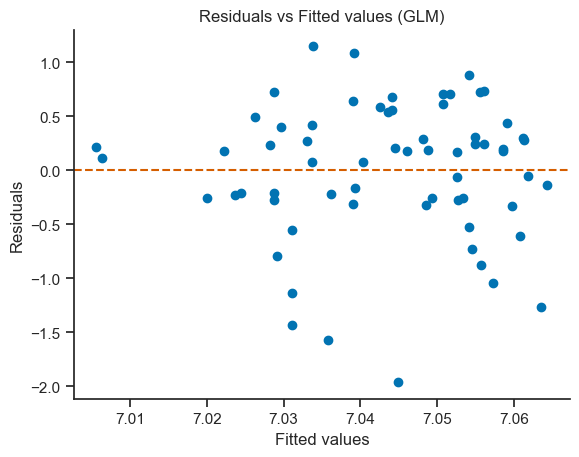

In [83]:

fitted_values = glm_model.fittedvalues
residuals = glm_model.resid_response

# Plot residuals vs fitted values
plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted values (GLM)")
plt.show()


## 4.2 Obligate and facultative scavengers

Now we want to include an interaction term in our regression to test the  We have two predictor variables, $x_1$ and $x_2$, for body size and diet. The first is quantitative continuous data, and the latter is categorical 

In [ ]:
import patsy 

logEOO = np.log10(scavengers["Extent of occurrence"])
logBodySize = np.log10(scavengers["Body size"])

# Make the design matrices with Patsy
y, X = patsy.dmatrices('logEOO ~ logBodySize * Diet', data=scavengers, return_type='dataframe')

dummy_interaction_OLS = sm.OLS(y, X).fit()
print(dummy_interaction_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                 logEOO   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.7522
Date:                Wed, 09 Apr 2025   Prob (F-statistic):              0.525
Time:                        13:45:27   Log-Likelihood:                -61.086
No. Observations:                  65   AIC:                             130.2
Df Residuals:                      61   BIC:                             138.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [62]:
# Extract coefficients from the model
intercept = dummy_interaction_OLS.params["Intercept"]
diet_obligate_coef = dummy_interaction_OLS.params["Diet[T.Obligate]"]
log_body_coef = dummy_interaction_OLS.params["logBodySize"]
interaction_coef = dummy_interaction_OLS.params["logBodySize:Diet[T.Obligate]"]

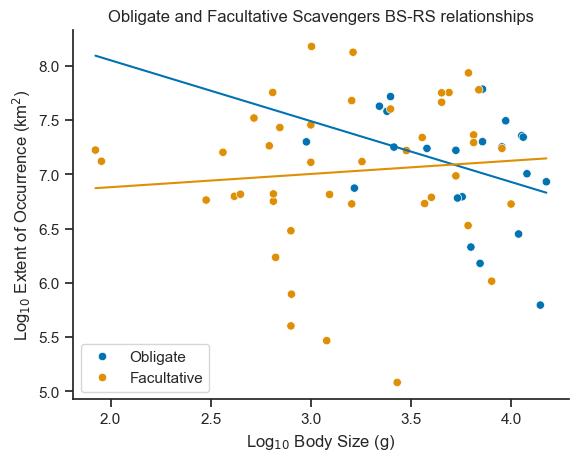

In [ ]:
log_body_values = np.linspace(
    np.log10(scavengers["Body size"]).min(),
    np.log10(scavengers["Body size"]).max(),
    100,
)

# Calculate regression lines for obligate and facultative scavengers
log_eoo_obligate = (
    intercept
    + log_body_coef * log_body_values
    + diet_obligate_coef
    + interaction_coef * log_body_values
)
log_eoo_facultative = intercept + log_body_coef * log_body_values

# Create a scatter plot with regression lines for obligate and facultative scavengers
sns.scatterplot(
    data=scavengers,
    x=np.log10(scavengers["Body size"]),
    y=np.log10(scavengers["Extent of occurrence"]),
    hue="Diet",
)

# Plot regression lines
plt.plot(log_body_values, log_eoo_obligate)
plt.plot(log_body_values, log_eoo_facultative)

plt.xlabel("Log$_{10}$ Body Size (g)")
plt.ylabel("Log$_{10}$ Extent of Occurrence (km$^2$)")
plt.legend()
plt.title("Obligate and Facultative Scavengers BS-RS relationships")

plt.show()

------------
# 5. References

BirdLife International (2025). IUCN Red List for birds. Last visited 2025-03-14. https://datazone.birdlife.org/

James H. Brown, Brian A. Maurer (1989). Macroecology: The Division of Food and Space Among Species on Continents. Science *243*, 1145-1150. [DOI:10.1126/science.243.4895.1145](https://doi.org/10.1126/science.243.4895.1145).